In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn import linear_model

from deepinv.physics.phase_retrieval import RandomPhaseRetrieval
from deepinv.optim.data_fidelity import L2
from deepinv.optim.phase_retrieval import spectral_methods, cosine_similarity

In [2]:
NUM_ITER = 1000
IMG_SHAPE = (3,10,10)
M = 5 * 300

In [3]:
physics = RandomPhaseRetrieval(M,IMG_SHAPE)
loss_fn = L2()

In [4]:
x = torch.randn((1,)+IMG_SHAPE,dtype=torch.cfloat)
y = physics(x)

print("x_norm:", torch.norm(x))
#print("y_norm:", torch.norm(y))
print("estimated x_norm:", torch.sqrt(y.sum()))

x_norm: tensor(17.8198)
estimated x_norm: tensor(17.9844)


In [11]:
# randomly initilize x_est and compute the cosine similarity between x_est and x
cosines = []
losses = []

for _ in range(1000):
    x_est = torch.randn_like(x)
    cosines.append(cosine_similarity(x, x_est))
    losses.append(loss_fn(x_est, y, physics))

print("cosine similarity:",np.mean(cosines))
print("loss:", np.mean(losses))

cosine similarity: 0.049376
loss: 61.7511


In [12]:
# initialize with spectral methods
cosines = []
losses = []

for _ in range(1):
    x_est = spectral_methods(y, physics, n_iter=100)
    x_est = x_est * torch.sqrt(y.sum())

    cosines.append(cosine_similarity(x, x_est))
    losses.append(loss_fn(x_est, y, physics))

print("cosine similarity:",np.mean(cosines))
print("loss:", np.mean(losses))

cosine similarity: 0.871478
loss: 22.0476


In [182]:
torch.angle(x_est / x)

tensor([[[[-2.6237e+00, -2.2530e+00, -3.2044e-01,  2.0371e+00,  1.4110e-01,
           -2.2375e+00, -2.8643e+00, -1.4943e+00,  2.0500e+00,  1.5053e+00,
           -2.5871e+00, -1.9555e+00,  2.3311e+00,  3.2421e-01,  6.7013e-01,
            4.5955e-01],
          [-2.2442e+00, -4.1522e-01,  2.5699e+00,  5.0800e-01,  1.3672e+00,
           -8.8911e-01,  2.7888e+00, -7.6840e-02, -2.5706e-01, -7.7521e-02,
            2.2121e+00,  2.2060e+00, -1.8744e+00, -2.7724e+00,  3.1698e-01,
            2.7905e+00],
          [ 2.2622e-01,  1.1100e+00, -2.3358e+00,  7.0454e-02, -1.0438e+00,
           -1.7378e+00,  1.6601e+00,  2.1906e+00,  1.7856e+00,  9.3579e-02,
           -2.9688e+00,  2.8389e+00, -3.6326e-01,  1.8772e+00,  7.6455e-01,
           -1.9487e+00],
          [-3.1178e-01,  2.2952e-01, -2.5647e-01,  1.1637e+00, -1.3691e+00,
           -3.1311e+00, -9.2079e-01, -1.9784e+00,  2.5147e+00, -1.1014e+00,
            1.5122e+00, -3.4375e-01,  2.9818e+00, -2.4629e-01, -1.3163e+00,
           -5

In [174]:
x[0,0,0]

tensor([0.2270+0.5479j, 0.4081+0.7657j, 0.0640+0.1188j, 0.7627+0.6490j,
        0.7882+0.0097j, 0.0652+0.3582j, 0.3713+0.0448j, 0.9036+0.1982j,
        0.0700+0.9095j, 0.6977+0.3347j, 0.5675+0.4506j, 0.2774+0.7840j,
        0.1212+0.0750j, 0.4959+0.0250j, 0.9745+0.6945j, 0.1770+0.2142j])

In [122]:
x_norms = []
A_norms = []
A_vars = []
y_norms = []
y_vars = []

for i in tqdm(range(NUM_ITER)):
    physics = RandomPhaseRetrieval(M,IMG_SHAPE)
    x = torch.rand((1,)+IMG_SHAPE,dtype=torch.cfloat)
    #print(x.shape)
    y = physics(x)
    #print(y.shape)
    x_norm = torch.norm(x.flatten())
    A_norm = torch.norm(physics.B._A)
    A_var = torch.var(physics.B._A)
    y_norm = torch.norm(y)
    y_var = torch.var(y)

    x_norms.append(x_norm)
    A_norms.append(A_norm)
    A_vars.append(A_var)
    y_norms.append(y_norm)
    y_vars.append(y_var)

  1%|          | 9/1000 [00:05<10:12,  1.62it/s]

Text(0.5, 1.0, 'y_vars vs x_norms')

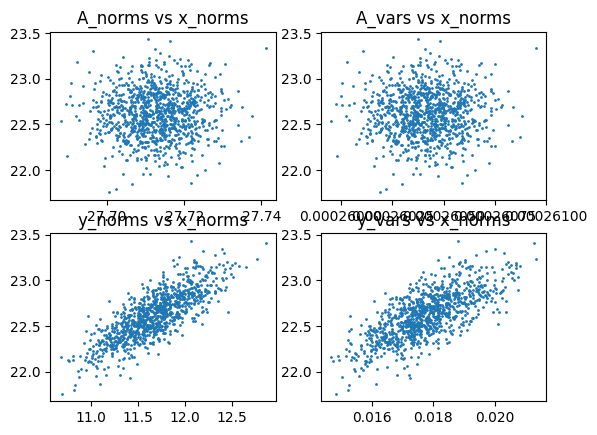

In [ ]:
# plot 4 figures showing the relationship between x_norms and A_norms/A_vars/y_norms/y_vars, using subplots and scatter plots
# make the scattered point size smaller
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(A_norms,x_norms,s=1)
axs[0, 0].set_title('A_norms vs x_norms')
axs[0, 1].scatter(A_vars,x_norms,s=1)
axs[0, 1].set_title('A_vars vs x_norms')
axs[1, 0].scatter(y_norms,x_norms,s=1)
axs[1, 0].set_title('y_norms vs x_norms')
axs[1, 1].scatter(y_vars,x_norms,s=1)
axs[1, 1].set_title('y_vars vs x_norms')

In [ ]:
model = linear_model.LinearRegression(fit_intercept=False)

model.fit(np.array(y_norms).reshape(-1,1), np.array(x_norms).reshape(-1,1))
model.coef_

array([[ 1.9367713]], dtype=float32)

In [52]:
physics = RandomPhaseRetrieval(M,IMG_SHAPE)
x = torch.rand((1,)+IMG_SHAPE,dtype=torch.cfloat)
y = physics(x)
xHx = x.flatten().conj().T @ x.flatten()
print('xHx:', xHx)
print("x_norm:", torch.norm(x))
print("estimate x_norm:", torch.sqrt(y.mean()*M))
print((y / xHx).mean())
print(M * (y / xHx).mean())

xHx: tensor(539.0738+0.j)
x_norm: tensor(23.2180)
estimate x_norm: tensor(23.1470)
tensor(0.0001+0.j)
tensor(0.9939+0.j)


/var/folders/g7/kcfjzxyn1klcs6f0xk8vby0w0000gn/T/ipykernel_92917/3094614910.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  xHx = x.flatten().conj().T @ x.flatten()


In [384]:
loss_fn = L2()
loss_fn(x, y, physics)

tensor([0.])

In [385]:
x_est = spectral_methods(50,torch.rand_like(x),y,physics)
x_est / x

tensor(1.)

In [430]:
print("loss before scaling",loss_fn(x_est, y, physics))
x_new = x_est * torch.sqrt(y.mean()*M)
print("x_norm:", torch.norm(x))
print("x_new_norm:", torch.norm(x_new))
print("loss after scaling",loss_fn(x_new, y, physics))

loss before scaling tensor([71.0060])
x_norm: tensor(22.7286)
x_new_norm: tensor(22.8618)
loss after scaling tensor([45.0234])


In [356]:
N = torch.prod(torch.tensor(IMG_SHAPE))
matrix = torch.randn((M, N), dtype=torch.cfloat) / np.sqrt(M)

x = torch.randn((N,), dtype=torch.cfloat)
y = (matrix @ x).abs()**2

xHx = x.conj().T @ x
print('xHx:', xHx)
print("x_norm:", torch.norm(x))
print("y_norm:", torch.sqrt(y.mean()*M))
print((y / xHx).mean())
print(M * (y / xHx).mean())

xHx: tensor(796.9452+0.j)
x_norm: tensor(28.2302)
y_norm: tensor(28.2988)
tensor(0.0003+0.j)
tensor(1.0049+0.j)


# Test spectral methods correctness

In [40]:
N = 2000
mat_A = torch.randn((N,N),dtype=torch.cfloat) / torch.sqrt(torch.tensor(N))
mat_A
x = torch.randn(N,dtype=torch.cfloat)
y = (mat_A @ x).abs()**2
#y

In [41]:
# construct matrix M
def preprocessing(y):
    return torch.max(1 - 1 / y, torch.tensor(-5.0))
mat_M = mat_A.conj().T @ torch.diag(preprocessing(y).squeeze()).to(torch.cfloat) @ mat_A
#print(mat_M)

# compute the principle eigenvector of M
eig_val, eig_vec = torch.linalg.eig(mat_M)

In [49]:
print(eig_val.real.max())
#print(eig_vec)

tensor(0.9493)


In [51]:
x_est = torch.rand(N, dtype=torch.cfloat)
x_est = x_est / torch.linalg.norm(x)

diag_T = preprocessing(y)
diag_T = diag_T.to(torch.cfloat)
print(diag_T)
for _ in range(100):
    res = mat_A @ x_est
    res = diag_T * res
    res = mat_A.conj().T @ res
    x_est = res + 10 * x_est
    x_est = x_est / torch.linalg.norm(x_est)
    #x = -x if x[0].real < 0 else x
print(cosine_similarity(x, x_est))
Mx = mat_M @ x_est
Mx/x_est 

tensor([-0.2513+0.j,  0.6623+0.j, -5.0000+0.j,  ...,  0.5484+0.j,  0.3241+0.j,
        -1.3153+0.j])
tensor(0.0276-0.0715j)


tensor([0.9046+0.0140j, 0.4765+0.1802j, 0.8886-0.0194j,  ...,
        0.9762-0.0976j, 0.8594+0.0600j, 0.8139-0.0745j])

# Test phase retrieval eigenvalue range

In [2]:
img_shape = (1, 32, 32)
m = 5 * 1 * 32 * 32
physics = RandomPhaseRetrieval(m, img_shape)
x = torch.rand((1,) + img_shape, dtype=torch.cfloat)
y = physics(x)
mat_A = physics.B._A
mat_A.var() * m

tensor(1.0003)

In [23]:
# construct matrix M
def preprocessing(y):
    return torch.max(1 - 1 / y, torch.tensor(-5.0))
#mat_M = mat_A.conj().T @ torch.diag(preprocessing(y).squeeze()).to(torch.cfloat) @ mat_A
mat_M = mat_A.conj().T @ mat_A
#print(mat_M)

# compute the principle eigenvector of M
eig_val, eig_vec = torch.linalg.eig(mat_M)

print(eig_val.real.min())
print(eig_val.real.max())
print(eig_val.real.mean())

tensor(0.6712)
tensor(1.3927)
tensor(0.9998)


In [6]:
eigenvalues = []
for i in range(M):
    row = matrix[i,:]
    mat = torch.einsum('i,j->ij',row,row)
    L, V = torch.linalg.eig(mat)
    eigenvalues.append(L[0].real)

KeyboardInterrupt: 

In [ ]:
row = matrix[0,:]
res = torch.einsum('i,j->ij',row,row.conj())
L, V = torch.linalg.eig(res)
L

tensor([ 1.9044e-01+1.8588e-09j,  3.9721e-09-4.5303e-09j,
        -3.5336e-09-4.5091e-09j, -1.1259e-09-5.4149e-09j,
        -2.2642e-09-4.8693e-09j,  4.8220e-09-2.9589e-09j,
         3.1344e-09+4.7444e-09j, -4.8490e-09+2.7792e-09j,
         7.0056e-10+5.3759e-09j, -2.0055e-09+5.0494e-09j,
        -3.0504e-09+4.4093e-09j,  5.4562e-09+8.6565e-10j,
         4.6287e-09+2.5858e-09j,  5.1668e-09-5.7130e-10j,
         4.6333e-09-1.8838e-09j,  4.8095e-09+2.0723e-10j,
         3.6286e-09+2.9968e-09j,  5.1622e-10-5.0224e-09j,
         1.0832e-09-4.7136e-09j,  2.2880e-09-4.0219e-09j,
        -7.0217e-10+4.8566e-09j, -5.3252e-09+1.3412e-10j,
        -4.7093e-09-2.3607e-09j, -4.7808e-09+1.0779e-09j,
        -4.6388e-09-9.7043e-10j, -3.9367e-09-2.5284e-09j,
         1.2902e-09+4.3297e-09j, -2.4770e-09+3.4466e-09j,
        -2.9592e-09+3.0118e-09j,  2.9709e-09+1.9071e-09j,
         2.5005e-09-2.1931e-09j, -2.4887e-09-2.0898e-09j,
        -1.4548e-09-9.7319e-10j,  9.1451e-10-1.2819e-09j,
         1.083